In [22]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import bipartite
import pandas as pd
import re
import matplotlib
font = {'family' : 'DejaVu Sans', 'weight' : 'normal', 'size'   : 22}
matplotlib.rc('font', **font)

In [23]:
def degree(g, nodes=None, as_list=True):
    deg = dict(g.degree())
    if nodes: deg = dict(g.degree(nodes))
    
    if as_list: return list(deg.values())
    return deg

def degree_plot(g, nodes=None, filename=None, title=''):
    font = {'family' : 'DejaVu Sans', 'weight' : 'normal', 'size'   : 22}
    matplotlib.rc('font', **font)
    deg = degree(g, nodes=nodes)
    bins = 100
    if len(nodes) < 100:
        bins = len(nodes)
    hist = np.histogram(deg, bins=bins)
    freqs, edges = hist[0], hist[1]
    n = freqs.size
    means = [(edges[i] + edges[i+1]) / 2 for i in range(n)]
    
    # SCATTER PLOT
    plt.figure(figsize=[15,10])
    plt.plot(means, freqs, ".", markersize=20)
    plt.xlabel("k")
    plt.ylabel("frequency")
    plt.title("Degree distribution for %s" % title)
    if filename: plt.savefig('plots/%s.svg' % filename, format='svg', bbox_inches="tight")
    plt.show()
    
    # LOG LOG PLOT
    plt.figure(figsize=[15,10])
    plt.loglog(means, freqs, ".", markersize=20)
    plt.xlabel("log(k)")
    plt.ylabel("log(frequency)")
    plt.title("Log-log degree distribution for %s" % title)
    if filename: plt.savefig('plots/log_%s.svg' % filename, format='svg', bbox_inches="tight")
    plt.show()

In [4]:
USER = 'user'
ELITE_USER = 'elite_user'
BIZ = 'biz'

In [5]:
biz = pd.read_csv('toronto/toronto_biz.csv')
user = pd.read_csv('toronto/toronto_users.csv')
reviews = pd.read_csv('toronto/toronto_reviews.csv')
elite_user = user[~user.elite.str.contains('None')]

In [6]:
print('#Reviews:', len(reviews))
print('#Users:', len(set(reviews.user_id)))
print('#Elite users:', len(elite_user))
print('#Businesses:', len(set(reviews.business_id)))

#Reviews: 379875
#Users: 84624
#Elite users: 7499
#Businesses: 9678


In [7]:
user.head()

,Unnamed: 0,average_stars,elite,friends,name,review_count,useful,user_id,yelping_since,ev
0,0,2.00,None,None,Susan,1,0,lzlZwIpuSWXEnNS91wxjHw,2015-09-28,0.000012
1,1,1.00,None,None,Ying,1,0,bwPVGW1Mx0qmS_qNQ7xmYg,2012-02-09,0.000065
2,2,3.50,None,None,Vai,4,0,JcKUiHAQ9cWGSO_qFbzlKw,2009-12-28,0.001124
3,3,1.75,None,None,Walter,4,1,mNzy0-YVTJTP2jqHR7zWwQ,2014-05-31,0.000262
4,4,2.00,None,None,K,3,0,AAxJbjcq94NaqUJGFE362g,2013-07-08,0.000045


## Social Network (Friends)
### Make friend List

In [8]:
elite_ids = set(elite_user.user_id)

In [9]:
users_with_friends = user[user.friends != 'None']

In [10]:
friend_list = dict()
for row in users_with_friends.itertuples():
    friend_list[row.user_id] = re.split(r',', row.friends)

### Creating the social network

In [11]:
# A node class for storing data.
class Node:
    def __init__(self, Data, Type):
        self.Data = Data
        self.Type = Type
    
    def to_string(self):
        return "Node (%s), Data: " % (self.Type, self.Data)
    
    def __hash__(self):
        return hash(self.Data)
    def __eq__(self, other):
        return (
                self.__class__ == other.__class__ and 
                self.Data == other.Data
               )

In [12]:
social_network = nx.Graph()
for uid in users_with_friends.user_id:
    a = Node(uid, ELITE_USER if uid in elite_ids else USER)
    for fid in friend_list[uid]:
        b = Node(fid, ELITE_USER if fid in elite_ids else USER)
        social_network.add_edge(a, b)

In [13]:
N,L = len(social_network.nodes()), len(social_network.edges())

print('Nodes:', N)
print('Edges:', L)

Nodes: 1552431
Edges: 3214980


#### Degree distributions

In [39]:
user_nodes = [n for n in list(social_network.nodes()) if n.Type == USER]
elite_nodes = [n for n in list(social_network.nodes()) if n.Type == ELITE_USER]
all_nodes = list(social_network.nodes())

In [15]:
print('Regular User Nodes:', len(user_nodes))
print('Elite User Nodes:', len(elite_nodes))

Regular User Nodes: 1544962
Elite User Nodes: 7469


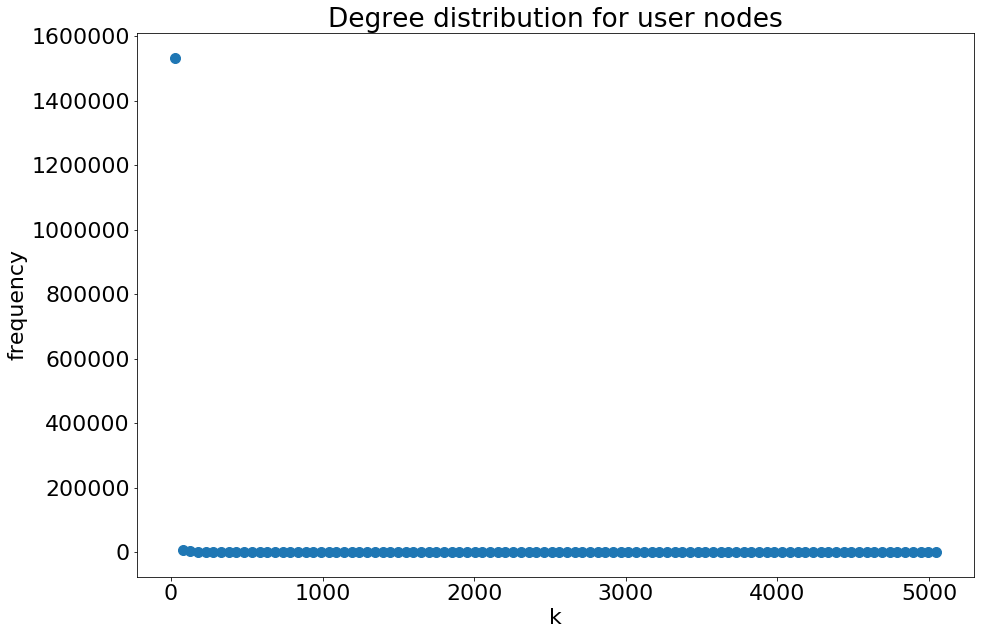

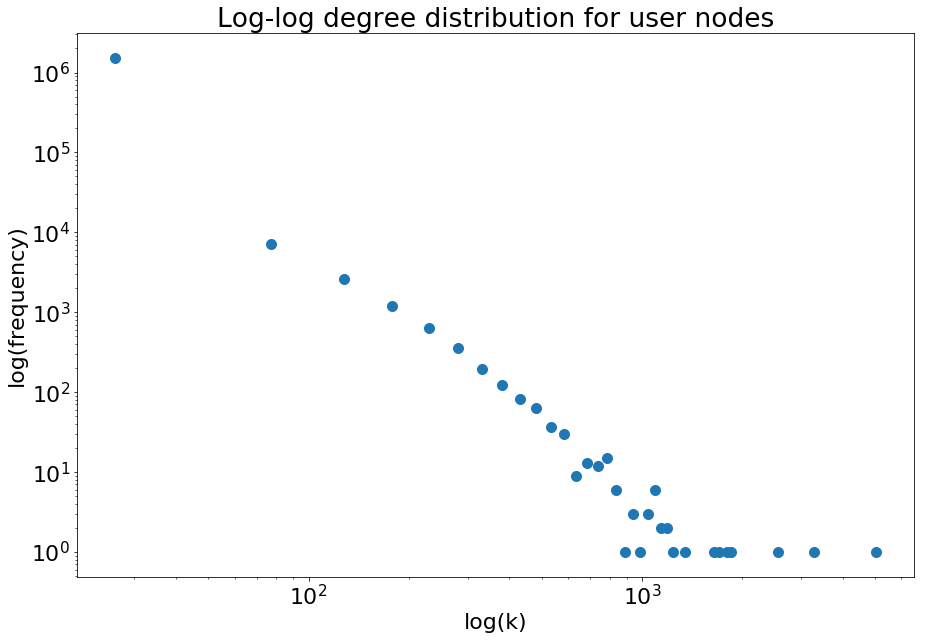

In [24]:
degree_plot(social_network, nodes=user_nodes, title="user nodes", filename='degree_social_regular')

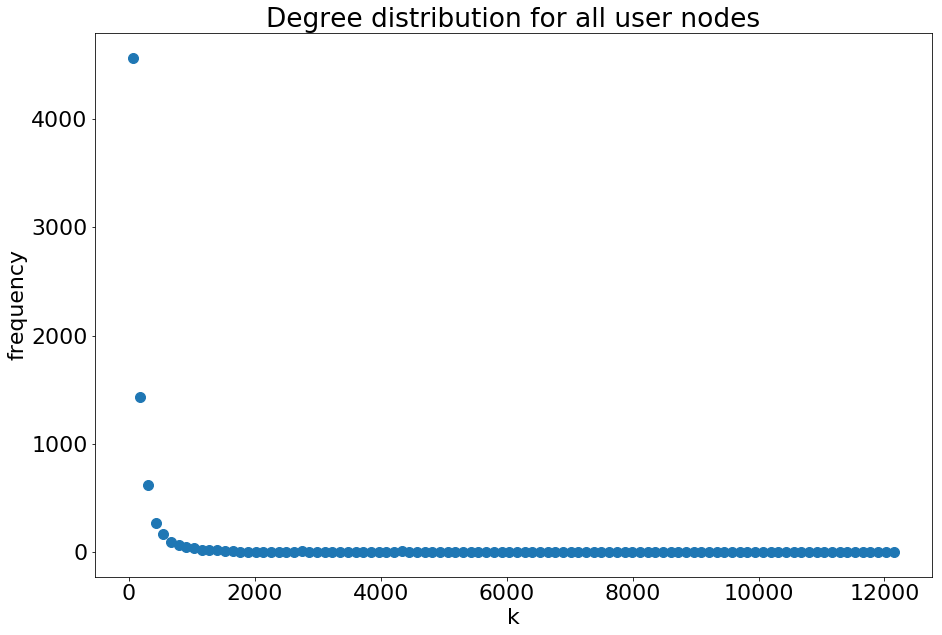

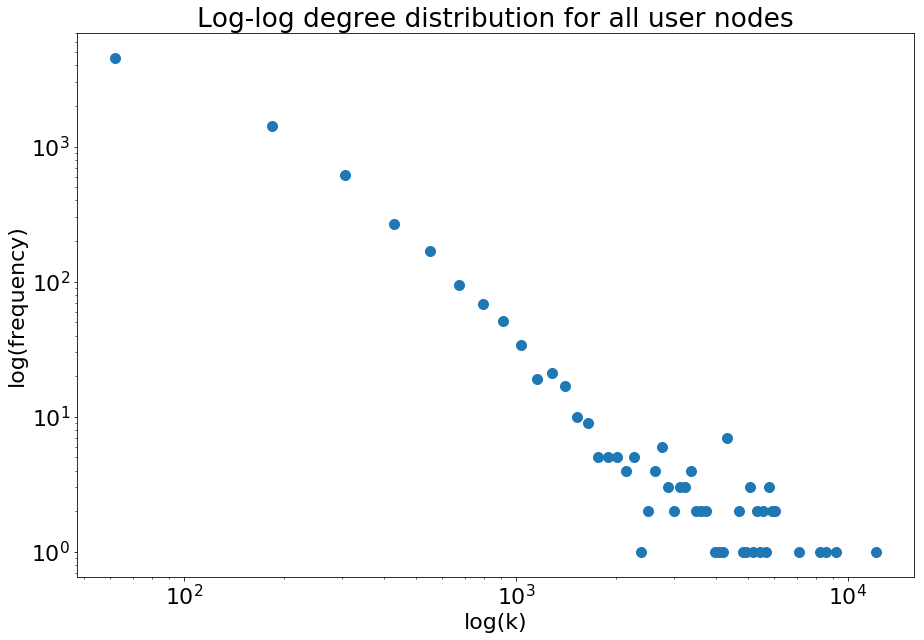

In [25]:
degree_plot(social_network, nodes=elite_nodes, title="all user nodes", filename='degree_social_all')

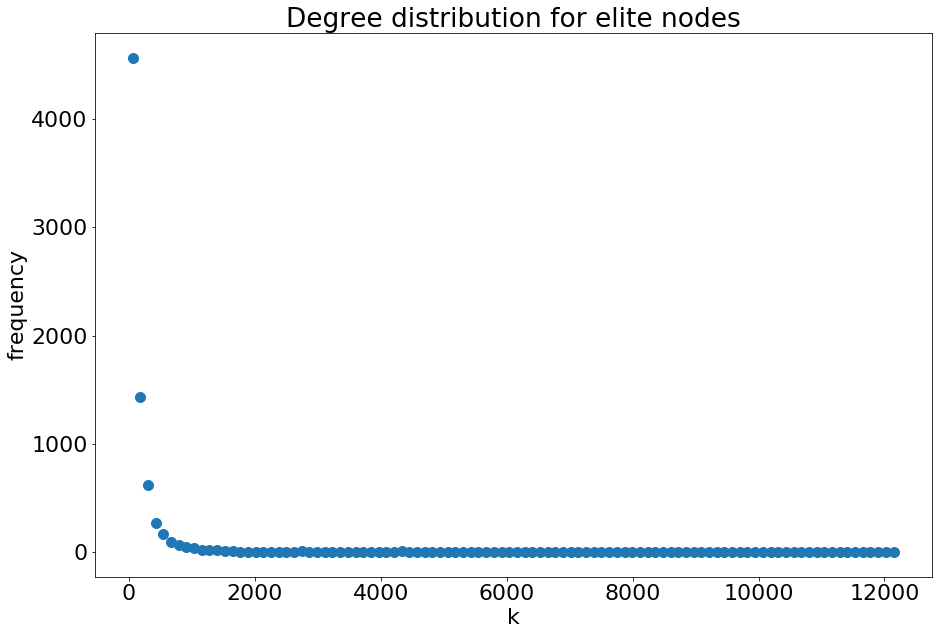

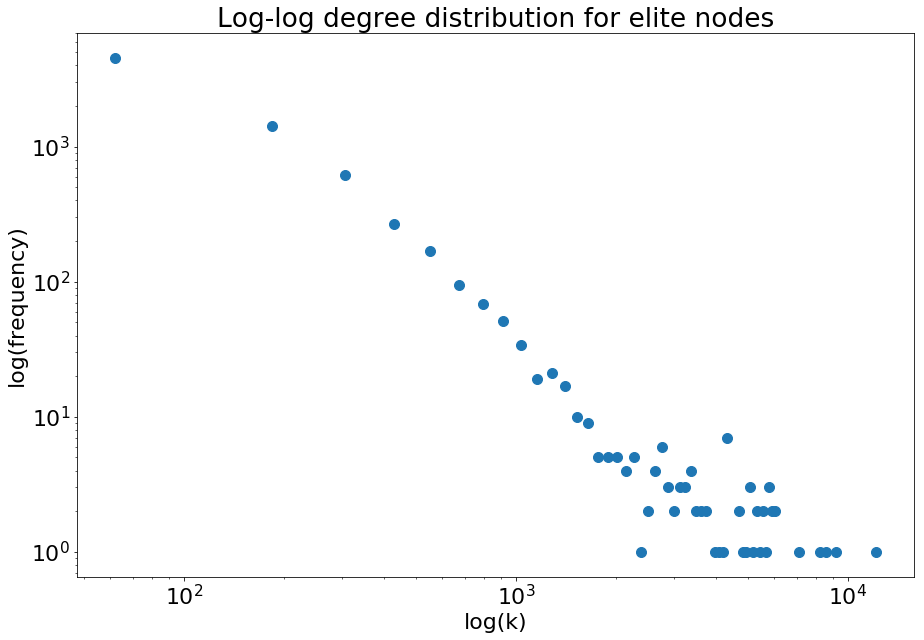

In [28]:
degree_plot(social_network, nodes=elite_nodes, title="elite nodes", filename='degree_social_elite')

In [19]:
print('Nodes:', len(social_network.nodes()))
print('Edges:', len(social_network.edges()))

Nodes: 1552431
Edges: 3214980


In [20]:
L = max(nx.connected_component_subgraphs(social_network), key=len)
print("Nodes in largest subcomponent:", len(L.nodes()))
print("Edges in largest subcomponent:", len(L.edges()))

KeyboardInterrupt: 

In [19]:
avg_clustering = nx.average_clustering(social_network)

In [20]:
avg_clustering

0.0009880679197519305

### Eigenvector Centrality

In [31]:
ev = nx.eigenvector_centrality_numpy(social_network)
ev_avg_elite = np.mean([ev[node]for node in ev if node.Type == ELITE_USER])
ev_avg_reg = np.mean([ev[node]for node in ev if node.Type == USER])
ev_avg_all = np.mean([ev[node]for node in ev if node.Type == USER or node.Type == ELITE_USER])

In [ ]:
ev_avg_elite, ev_avg_reg, ev_avg_all

### Degree Centrality

In [32]:
dg = nx.degree_centrality(social_network)
dg_avg_elite = np.mean([dg[node]for node in dg if node.Type == ELITE_USER])
dg_avg_reg = np.mean([dg[node]for node in dg if node.Type == USER])
dg_avg_all = np.mean([dg[node]for node in dg if node.Type == USER or node.Type == ELITE_USER])

In [ ]:
dg_avg_elite, dg_avg_reg, dg_avg_all

In [40]:
elite_degree_centralities = np.array([dg[node] for node in elite_nodes]) 
elite_ev_centralities = np.array([ev[node] for node in elite_nodes]) 

reg_degree_centralities = np.array([dg[node] for node in user_nodes]) 
reg_ev_centralities = np.array([ev[node] for node in user_nodes]) 

all_degree_centralities = np.array([dg[node] for node in all_nodes]) 
all_ev_centralities = np.array([ev[node] for node in all_nodes]) 

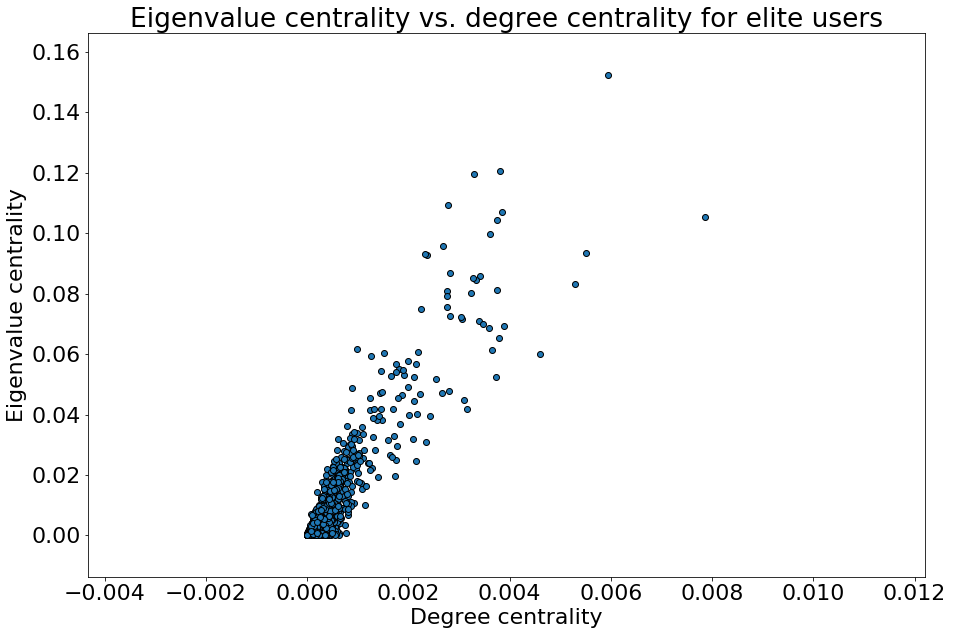

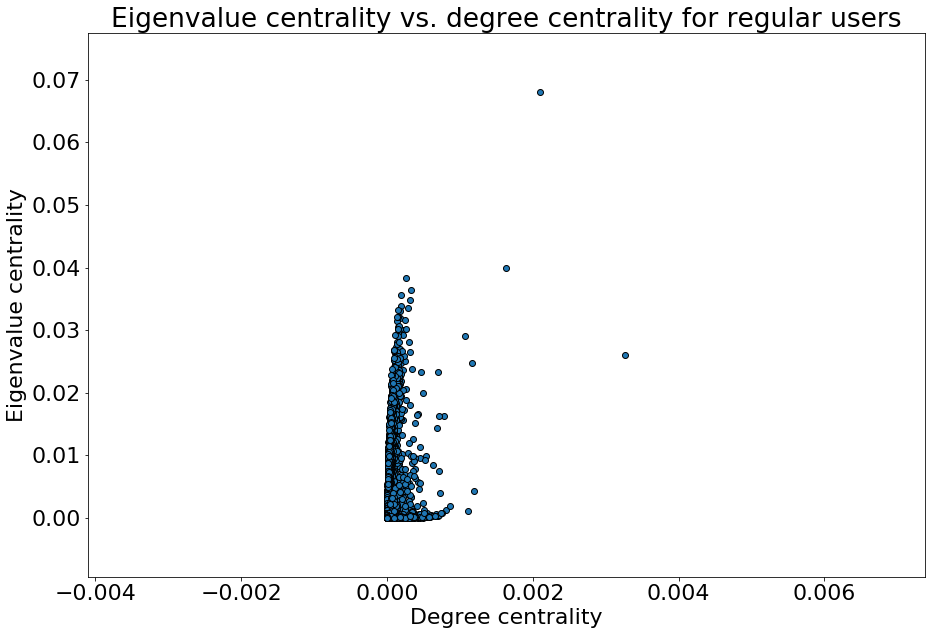

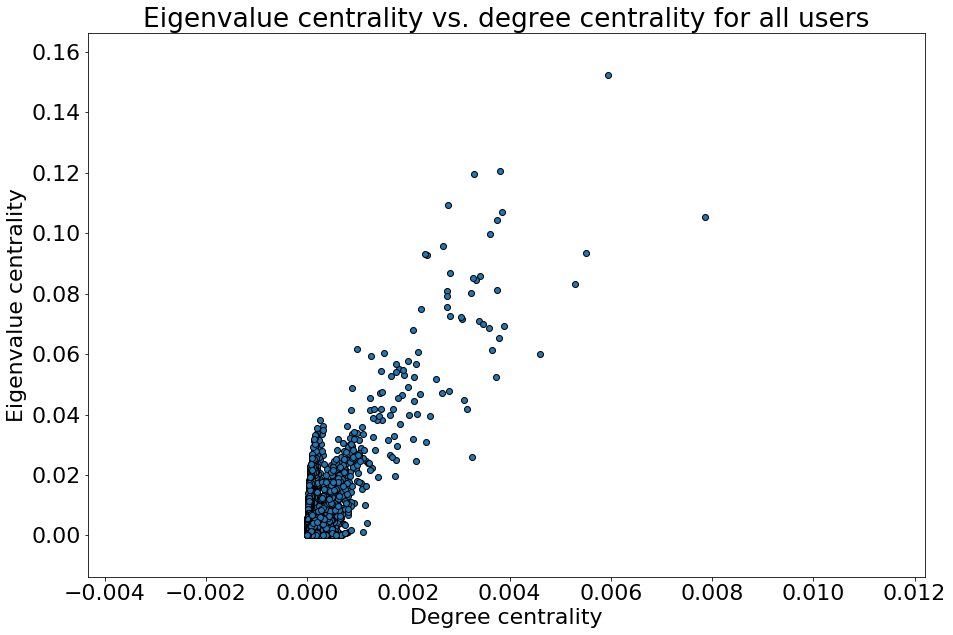

In [41]:
plt.figure(figsize=[15,10])
plt.scatter(elite_degree_centralities, elite_ev_centralities, edgecolor='black')
plt.xlabel('Degree centrality')
plt.ylabel('Eigenvalue centrality')
plt.title('Eigenvalue centrality vs. degree centrality for elite users')
plt.show()

plt.figure(figsize=[15,10])
plt.scatter(reg_degree_centralities, reg_ev_centralities, edgecolor='black')
plt.xlabel('Degree centrality')
plt.ylabel('Eigenvalue centrality')
plt.title('Eigenvalue centrality vs. degree centrality for regular users')
plt.show()

plt.figure(figsize=[15,10])
plt.scatter(all_degree_centralities, all_ev_centralities, edgecolor='black')
plt.xlabel('Degree centrality')
plt.ylabel('Eigenvalue centrality')
plt.title('Eigenvalue centrality vs. degree centrality for all users')
plt.show()

In [ ]:
plt.figure(figsize=[15,10])
plt.scatter(elite_degree_centralities, elite_ev_centralities, edgecolor='black')
plt.xlabel('Degree centrality')
plt.ylabel('Eigenvalue centrality')
plt.show()

In [ ]:
plt.figure(figsize=[15,10])
plt.scatter(elite_degree_centralities, elite_ev_centralities, edgecolor='black')
plt.xlabel('Degree centrality')
plt.ylabel('Eigenvalue centrality')
plt.show()

### Removing elite users

#### Robustness analysis

In [ ]:
def robustness_analysis(graph, nodes, one_percent_of_users):
    k = 100
    random.shuffle(nodes)

    # Initialize array for LCC sizes
    lcc_values = np.zeros(k)

    # Start loop
    for i in range(k):
        print(str(i) + " percent removed.")
        print("Network size: " + str(len(graph)))

        # Compute largest connected subcomponent
        mcc = len(max(nx.connected_component_subgraphs(graph), key=len))
        lcc_values[i] = mcc
        print("Largest connected component: " + str(mcc))

        # Remove 1 percent of users, randomly chosen
        for j in range(one_percent_of_users):
            node = nodes.pop()
            graph.remove_node(node)

In [ ]:
one_percent = int(len()*0.01)

In [157]:
lcc_all = pd.read_csv('Remove_All_LCC_based_on_elite_size.txt', header=None, names=['data'])
lcc_reg = pd.read_csv('Remove_Non_Elites_LCC_based_on_elite_size.txt', header=None, names=['data'])
lcc_elite = pd.read_csv('Remove_Elites_LCC.txt', header=None, names=['data'])

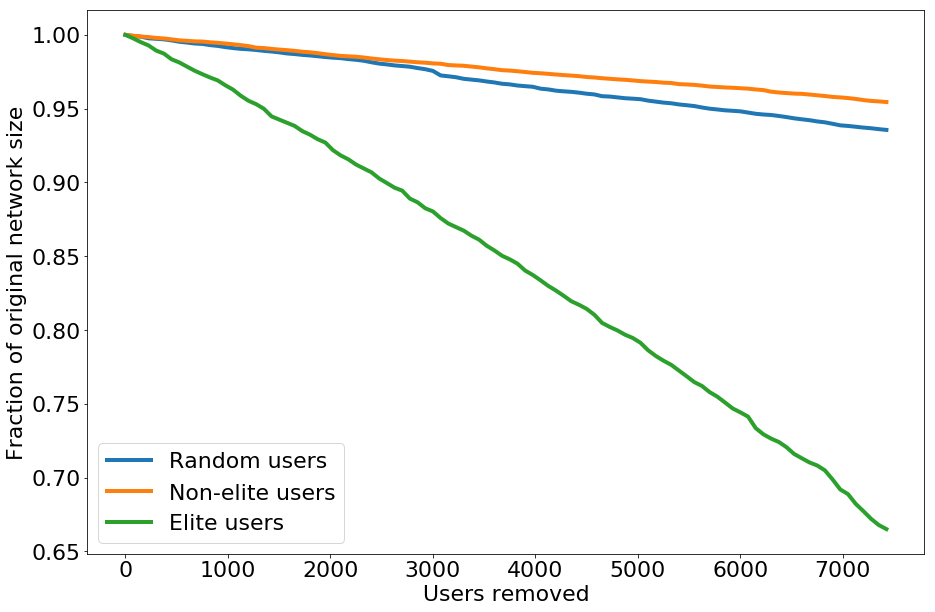

In [182]:
plt.figure(figsize=[15,10])
plt.plot(x_ax, lcc_all.data / lcc_all.data.max(), linewidth=4)
plt.plot(x_ax, lcc_reg.data / lcc_reg.data.max(), linewidth=4)
plt.plot(x_ax, lcc_elite.data / lcc_elite.data.max(), linewidth=4)
plt.legend(['Random users', 'Non-elite users', 'Elite users'])
plt.xlabel('Users removed')
plt.ylabel('Fraction of original network size')
plt.savefig('plots/robustness_plot.svg', format='svg', bbox_inches="tight")
plt.show()

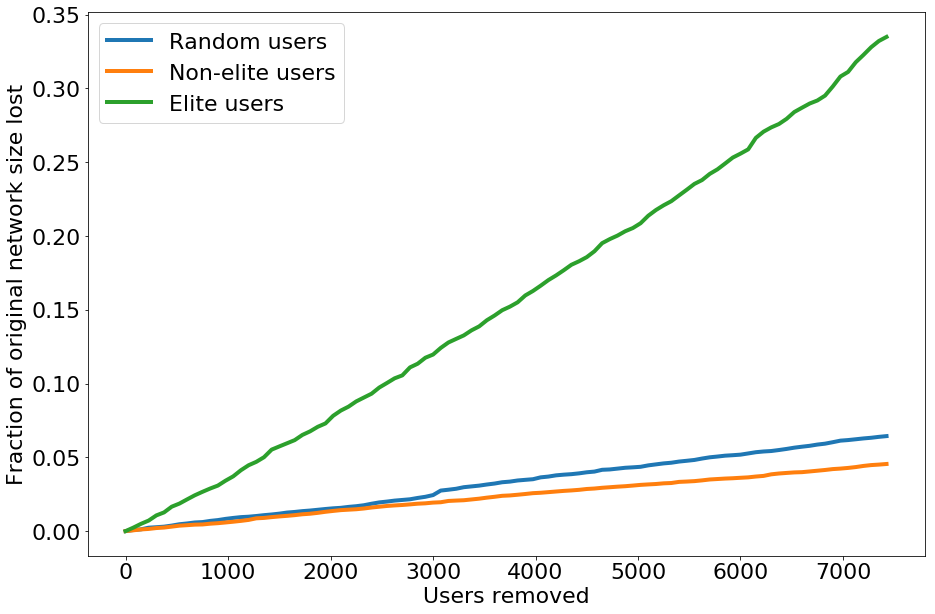

In [185]:
x_ax = 75 * np.arange(0,100)
plt.figure(figsize=[15,10])
plt.plot(x_ax, 1 - lcc_all.data / lcc_all.data.max(), linewidth=4)
plt.plot(x_ax, 1 - lcc_reg.data / lcc_reg.data.max(), linewidth=4)
plt.plot(x_ax, 1 - lcc_elite.data / lcc_elite.data.max(), linewidth=4)
plt.legend(['Random users', 'Non-elite users', 'Elite users'])
plt.xlabel('Users removed')
plt.ylabel('Fraction of original network size lost')
plt.savefig('plots/robustness_plot.svg', format='svg', bbox_inches="tight")
plt.show()